# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

tf.random.set_seed(seed=42)

# Define Function

I defined this function to allow me to plot the loss and accuracy across multiple CNN models.

The purpose of this is since I will be using multiple times, I will define a function.

In [4]:
def plotting(df:pd.DataFrame, temp_list:list):
  ax = plt.subplots(1,1)

  # Plotting multiple lines on 1 figure
  sns.lineplot(data=df, x=df.index, y=temp_list[0], label= 'train_' + temp_list[0])
  sns.lineplot(data=df, x=df.index, y=temp_list[1], label= temp_list[1])

  # Setting labels for axis
  plt.xlabel(xlabel='epoch (s)', fontsize=12);
  plt.ylabel(ylabel= temp_list[0], fontsize=12)

  # Set title
  plt.title(label= temp_list[0] + ' vs epochs', fontsize=16)
  plt.show();

### Define ROC AUC Function

In [5]:
def plot_roc(predictions_probability, test):

  no_skill_probability = [0 for _ in range(len(test))]
  no_skill_auc = roc_auc_score(test, no_skill_probability)
  no_skill_fpr, no_skill_tpr, _ = roc_curve(test, no_skill_probability)

  model_auc = roc_auc_score(test, predictions_probability)
  model_fpr, model_tpr, _ = roc_curve(test, predictions_probability)

  print(f'No Skill: {no_skill_auc}')
  print(f'Model: {model_auc}')

  plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
  plt.plot(model_fpr, model_tpr, linestyle='dotted', label='Model')
  plt.show();

### Define Function to do almost everything

In [18]:
def do_everything(model, model_name, number_of_epochs=10):

  # Fitting Model
  model.fit(x=train,
            epochs=number_of_epochs,
            validation_data=val,
            class_weight=class_weights)

  # Obtain Model history and save it
  globals()[model_name] = pd.DataFrame(model.history.history)
  globals()[model_name].to_csv(path_or_buf=f'./Data/Models/{model_name}.csv')
  temp_df = globals()[model_name]

  print('\n')

  # Plot loss graph
  plotting(df=temp_df, temp_list=['loss', 'val_loss'])
  print('\n')
  # Plot accuracy graph
  plotting(df=temp_df, temp_list=['accuracy', 'val_accuracy'])

  print('\n')

  # Obtaining Predictions
  predictions_proba = model.predict(val)
  predictions = predictions_proba > 0.5

  # Classification Report
  print(classification_report(y_true=val.classes, y_pred=predictions))

  print('\n')

  # Confusion Matrix
  cm = confusion_matrix(y_true=val.classes, y_pred=predictions)
  display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train.class_indices.keys()).plot()
  plt.show()

  print('\n')

  # ROC Curve / AUC
  plot_roc(predictions_probability=predictions_proba, test=val.classes)

  # Save Model
  model.save(filepath=f'./Data/Models/{model_name}.keras')

# Data

In [19]:
IDG = ImageDataGenerator(rescale=(1/255))

train = IDG.flow_from_directory(directory='./Data/train',
                                target_size=(50,50),
                                color_mode='rgb',
                                class_mode='binary',
                                batch_size=32,
                                shuffle=True,
                                seed=42)

val = IDG.flow_from_directory(directory='./Data/val',
                                target_size=(50,50),
                                color_mode='rgb',
                                class_mode='binary',
                                batch_size=32,
                                shuffle=True,
                                seed=42)

Found 1717 images belonging to 2 classes.
Found 431 images belonging to 2 classes.


In [20]:
train.class_indices

{'Kirmizi_Pistachio': 0, 'Siirt_Pistachio': 1}

In [21]:
val.class_indices

{'Kirmizi_Pistachio': 0, 'Siirt_Pistachio': 1}

# Compute Class Weight

In [22]:
np.unique(train.classes)

array([0, 1])

In [23]:
class_weights = {}

for i,j in zip(np.unique(train.classes), class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(train.classes),y=train.classes)):
  class_weights[i] = j

class_weights

{0: 0.8715736040609137, 1: 1.1728142076502732}

# Model Building

## MobileNet

In [24]:
model = Sequential()

model.add(layer=MobileNet(include_top=False, weights='imagenet', input_shape=(50,50,3)))

model.add(layer=GlobalAveragePooling2D())

model.add(layer=(Dense(units=1, activation='sigmoid')))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1, 1, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3229889 (12.32 MB)
Trainable params: 3208001 (12.24 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


Epoch 1/10
54/54 [==============================] - 29s 377ms/step - loss: 0.6612 - accuracy: 0.8125 - val_loss: 3.1592 - val_accuracy: 0.4269
Epoch 2/10
54/54 [==============================] - 5s 100ms/step - loss: 0.3175 - accuracy: 0.8888 - val_loss: 3.1856 - val_accuracy: 0.4408
Epoch 3/10
54/54 [==============================] - 6s 103ms/step - loss: 0.1847 - accuracy: 0.9202 - val_loss: 0.3459 - val_accuracy: 0.8608
Epoch 4/10
54/54 [==============================] - 5s 91ms/step - loss: 0.1551 - accuracy: 0.9476 - val_loss: 0.4476 - val_accuracy: 0.8121
Epoch 5/10
54/54 [==============================] - 6s 102ms/step - loss: 0.1263 - accuracy: 0.9534 - val_loss: 0.2351 - val_accuracy: 0.8956
Epoch 6/10
54/54 [==============================] - 5s 95ms/step - loss: 0.1380 - accuracy: 0.9552 - val_loss: 0.6000 - val_accuracy: 0.8005
Epoch 7/10
54/54 [==============================] - 5s 98ms/step - loss: 0.0986 - accuracy: 0.9656 - val_loss: 0.3144 - val_accuracy: 0.8979
Epoch 8/

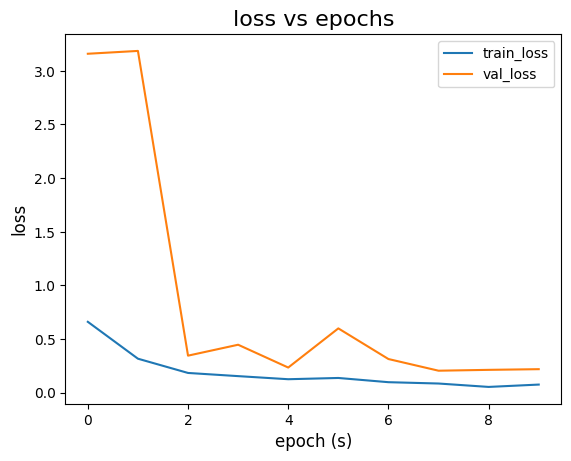

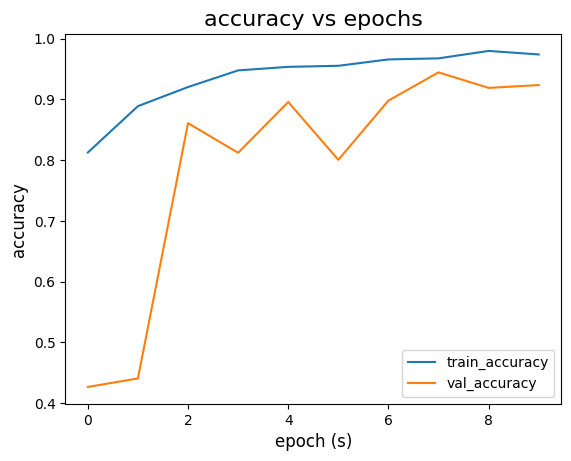



14/14 [==============================] - 1s 44ms/step
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       247
           1       0.37      0.32      0.34       184

    accuracy                           0.48       431
   macro avg       0.46      0.46      0.46       431
weighted avg       0.47      0.48      0.47       431





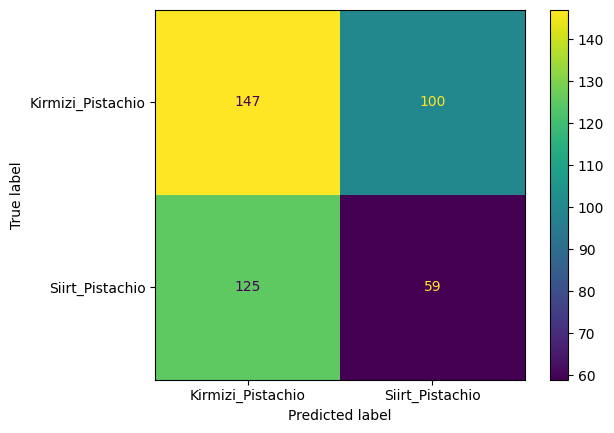



No Skill: 0.5
Model: 0.4207445872205598


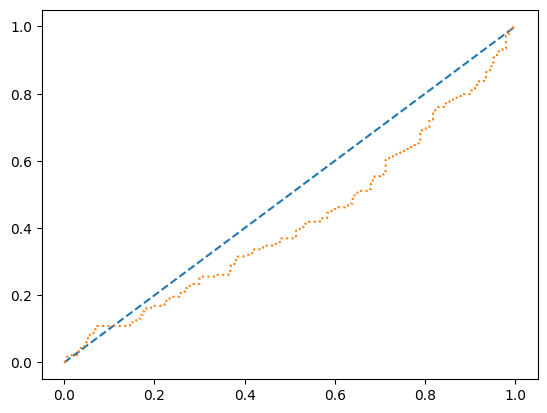

In [26]:
do_everything(model=model, model_name='mobilenet')

### Summary

*   From the loss graph, the validation loss starts to increase after 4 - 5 epochs
*   In addition, similar to convolutional neural networks built from scratch, Kirmizi Pistachios wrongly predicted to be Siirt make up the majority of misclassification
*   This model is not doing much better with the accuracy only being 0.48

## MobileNetV2

In [27]:
model = Sequential()

model.add(layer=MobileNetV2(include_top=False, weights='imagenet', input_shape=(50,50,3)))

model.add(layer=GlobalAveragePooling2D())

model.add(layer=(Dense(units=1, activation='sigmoid')))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 4s 0us/step


In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 2225153 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


Epoch 1/10


54/54 [==============================] - 22s 130ms/step - loss: 0.4653 - accuracy: 0.7962 - val_loss: 32.5314 - val_accuracy: 0.4269
Epoch 2/10
54/54 [==============================] - 6s 109ms/step - loss: 0.2760 - accuracy: 0.8975 - val_loss: 30.1712 - val_accuracy: 0.4269
Epoch 3/10
54/54 [==============================] - 6s 111ms/step - loss: 0.1841 - accuracy: 0.9284 - val_loss: 37.8645 - val_accuracy: 0.4269
Epoch 4/10
54/54 [==============================] - 6s 106ms/step - loss: 0.1387 - accuracy: 0.9447 - val_loss: 28.1507 - val_accuracy: 0.4269
Epoch 5/10
54/54 [==============================] - 6s 106ms/step - loss: 0.0916 - accuracy: 0.9633 - val_loss: 28.1406 - val_accuracy: 0.4292
Epoch 6/10
54/54 [==============================] - 6s 106ms/step - loss: 0.1281 - accuracy: 0.9546 - val_loss: 27.5451 - val_accuracy: 0.4269
Epoch 7/10
54/54 [==============================] - 6s 107ms/step - loss: 0.0958 - accuracy: 0.9627 - val_loss: 28.4435 - val_accuracy: 0.4269
Epoch 8/1

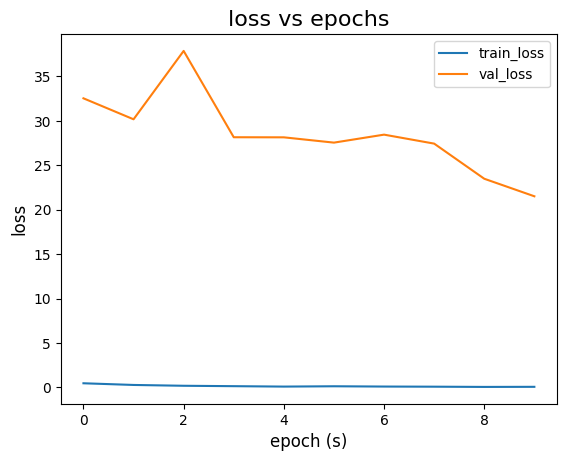

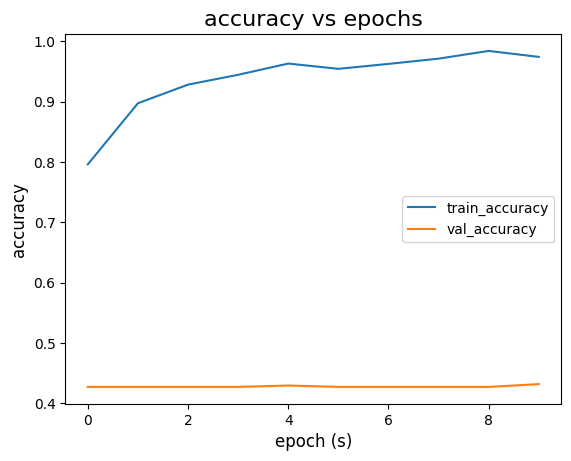



14/14 [==============================] - 2s 44ms/step
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       247
           1       0.43      0.99      0.60       184

    accuracy                           0.43       431
   macro avg       0.46      0.50      0.30       431
weighted avg       0.47      0.43      0.26       431





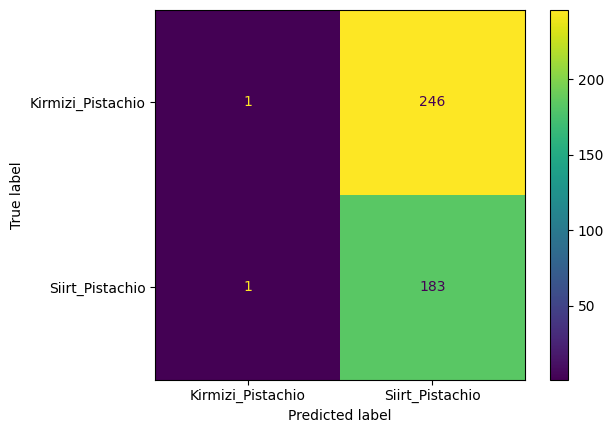



No Skill: 0.5
Model: 0.5017822566449569


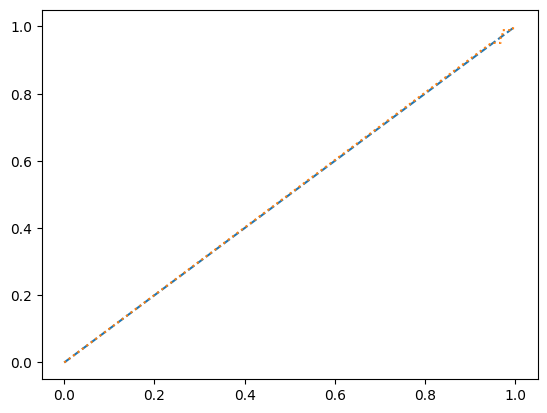

In [29]:
do_everything(model=model, model_name='mobilenetV2')

### Summary

*   From the loss graph, the validation loss starts to increase after 4 - 5 epochs